In [1]:
import os
notebook_dir = os.getcwd()
root_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
data_dir = os.path.join(root_dir, 'data')
import numpy as np
import pandas as pd
from sklearn.metrics import brier_score_loss, make_scorer, log_loss, mean_squared_error
from IPython.display import display_html
from copy import deepcopy
import pickle
from sklearn import calibration
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier, MLPRegressor
import ipywidgets as widgets
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import GroupKFold, RandomizedSearchCV, cross_val_predict, GridSearchCV
# from utils.utils

In [2]:
def normalize_df(df, anchor_df=None):
    for col in df.columns:
        data = df[col]
        if anchor_df is None:
            df[col] = (data - np.min(data)) / (np.max(data) - np.min(data))
        else:
            df[col] = (data - np.min(anchor_df[col])) / (np.max(anchor_df[col]) - np.min(anchor_df[col]))
    return df

def create_train_test_val_df(
    df,
    input_names,
    output_name,
    group_col="game_code",
    mask_test_season=2021,
    mask_val_season=[2019, 2020],
    normalize=False
):
    mask_train = ~(df.season.isin([mask_test_season] + mask_val_season))
    mask_test = (df.season == mask_test_season)
    mask_val = (df.season.isin(mask_val_season))
    if normalize==False:
        X_train = df.loc[mask_train, input_names]
        X_test = df.loc[mask_test, input_names]
        X_val = df.loc[mask_val, input_names]
    else:
        X_train = normalize_df(df.loc[mask_train, input_names])
        X_test = normalize_df(df.loc[mask_test, input_names], df.loc[mask_train, input_names])
        X_val = normalize_df(df.loc[mask_val, input_names], df.loc[mask_train, input_names])
    y_train = df[mask_train][output_name]
    group_train = df[mask_train][group_col]
    y_test = df[mask_test][output_name]
    group_test = df[mask_test][group_col]
    y_val = df[mask_val][output_name]
    group_val = df[mask_val][group_col]
    return X_train, y_train, group_train, X_test, y_test, group_test, X_val, y_val, group_val

In [3]:
pd.set_option("display.max_columns", None)
model_df = pd.read_parquet("model_outputs_cfb.parquet")
input_names_play_and_drive_preds = [
    'time_left_in_half',
    'half',
    'current_score_diff',
    'current_score_total',
    # 'home_vegas_score_pred_weighted',
    # 'away_vegas_score_pred_weighted',
    'cur_spread',
    'cur_over_under',
    'home_timeouts_remaining',
    'away_timeouts_remaining',
    'ytg',
    'yd_from_goal',
    'down',
    'home_team_has_ball',
]
input_names_score_diff_pred = input_names_play_and_drive_preds + [
    'kick_off',
    'point_after_play',
    'search_rf_play_first_down_home',
    'search_rf_play_first_down_away',
    'search_rf_drive_field_goal_made_home',
    'search_rf_drive_field_goal_missed_home',
    'search_rf_drive_punt_home',
    'search_rf_drive_safety_home',
    'search_rf_drive_touch_down_home',
    'search_rf_drive_turnover_home',
    'search_rf_drive_turnover_on_downs_home',
    'search_rf_drive_field_goal_made_away',
    'search_rf_drive_field_goal_missed_away',
    'search_rf_drive_punt_away',
    'search_rf_drive_safety_away',
    'search_rf_drive_touch_down_away',
    'search_rf_drive_turnover_away',
    'search_rf_drive_turnover_on_downs_away'
]
scrimmage_plays_we_want = [1, 2, 3, 4, 7, 9, 14, 17, 18, 35]



In [4]:
scrimmage_plays_we_want = [1, 2, 3, 4, 7, 9, 14, 17, 18, 35]


In [5]:
model_df["kicking_vegas_pred"] = np.where(model_df["home_team_has_ball"] == 1, model_df["home_vegas_score_pred"], model_df["away_vegas_score_pred"])
model_df["receiving_vegas_pred"] = np.where(model_df["home_team_has_ball"] == 0, model_df["home_vegas_score_pred"], model_df["away_vegas_score_pred"])


model_no_continuation = model_df[(model_df.continuation==0)&(model_df.play_counts==1)&(model_df.yd_from_goal!=-1)].reset_index(drop=True)


In [6]:
punt_data = model_no_continuation[model_no_continuation["punt"]==1][input_names_play_and_drive_preds + ["event_name", "play_counts", "yards_gained", "season", "home_vegas_score_pred", "away_vegas_score_pred", "game_code", "nevent"]].reset_index(drop=True)
punt_result = model_no_continuation[model_no_continuation.shift(1)["punt"]==1][input_names_play_and_drive_preds + ["event_name", "play_counts", "yards_gained", "season"]].reset_index(drop=True)
punt_data["opponent_field_position"] = punt_result["yd_from_goal"]
punt_data["next_play"] = punt_result["event_name"]
punt_data["kicking_vegas_pred"] = np.where(punt_data["home_team_has_ball"] == 1, punt_data["home_vegas_score_pred"], punt_data["away_vegas_score_pred"])
punt_data["receiving_vegas_pred"] = np.where(punt_data["home_team_has_ball"] == 0, punt_data["home_vegas_score_pred"], punt_data["away_vegas_score_pred"])
punt_data = punt_data.dropna()

In [7]:
mlp_punt_field_position = MLPRegressor(hidden_layer_sizes=[100], verbose=True, early_stopping=True, n_iter_no_change=5, random_state=1)
input_names_punt = [
    'time_left_in_half',
    'half',
    'current_score_diff',
    'current_score_total',
    'kicking_vegas_pred',
    'receiving_vegas_pred',
    'yd_from_goal',
    'home_team_has_ball',    
]
X_train, y_train, group_train, X_test, y_test, group_test, X_val, y_val, group_val = create_train_test_val_df(punt_data, input_names_punt, "opponent_field_position", normalize=True)
mlp_punt_field_position.fit(X_train, y_train)


punt_data["xopponent_field_position"] = mlp_punt_field_position.predict(pd.concat([X_train, X_val, X_test])[input_names_punt])

Iteration 1, loss = 2180.34962039
Validation score: -7.702577
Iteration 2, loss = 574.26802888
Validation score: -0.923542


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(


Iteration 3, loss = 246.35504728
Validation score: -0.700425
Iteration 4, loss = 225.39247118
Validation score: -0.543839


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(


Iteration 5, loss = 201.97200628
Validation score: -0.368737


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(


Iteration 6, loss = 180.66071464
Validation score: -0.223690
Iteration 7, loss = 162.10152637
Validation score: -0.095604


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(


Iteration 8, loss = 145.49248198
Validation score: 0.021714
Iteration 9, loss = 130.38201565
Validation score: 0.125979


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(


Iteration 10, loss = 117.41149609
Validation score: 0.210335
Iteration 11, loss = 107.08884894
Validation score: 0.274013


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(


Iteration 12, loss = 99.54684790
Validation score: 0.319895
Iteration 13, loss = 94.29775012
Validation score: 0.351010


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(


Iteration 14, loss = 90.72927377
Validation score: 0.372334
Iteration 15, loss = 88.15583038
Validation score: 0.388145


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(


Iteration 16, loss = 86.22287679
Validation score: 0.398960
Iteration 17, loss = 84.73848877
Validation score: 0.409193


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(


Iteration 18, loss = 83.43158007
Validation score: 0.416961
Iteration 19, loss = 82.40902670
Validation score: 0.423815


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(


Iteration 20, loss = 81.52878688
Validation score: 0.428746
Iteration 21, loss = 80.73909153
Validation score: 0.433122


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(


Iteration 22, loss = 80.14866241
Validation score: 0.436293
Iteration 23, loss = 79.59480943
Validation score: 0.441086


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(


Iteration 24, loss = 79.15029874
Validation score: 0.442509
Iteration 25, loss = 78.78414586
Validation score: 0.445517


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(


Iteration 26, loss = 78.43004100
Validation score: 0.448080
Iteration 27, loss = 78.21787865
Validation score: 0.449634


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(


Iteration 28, loss = 77.95939914
Validation score: 0.451203
Iteration 29, loss = 77.79643524
Validation score: 0.450766


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(


Iteration 30, loss = 77.63029721
Validation score: 0.452786
Iteration 31, loss = 77.45520117
Validation score: 0.453571


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(


Iteration 32, loss = 77.36722861
Validation score: 0.454635
Iteration 33, loss = 77.26735116
Validation score: 0.455690


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(


Iteration 34, loss = 77.15755842
Validation score: 0.456321
Iteration 35, loss = 77.03835633
Validation score: 0.454210


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(


Iteration 36, loss = 76.99783008
Validation score: 0.457424
Iteration 37, loss = 77.05879389
Validation score: 0.458209


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(


Iteration 38, loss = 76.86983936
Validation score: 0.458562
Iteration 39, loss = 76.85506420
Validation score: 0.455215


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(


Iteration 40, loss = 76.74822402
Validation score: 0.459376
Iteration 41, loss = 76.72664674
Validation score: 0.458649


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(


Iteration 42, loss = 76.70820080
Validation score: 0.456891
Iteration 43, loss = 76.63102697
Validation score: 0.459415


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(


Iteration 44, loss = 76.67760028
Validation score: 0.455819
Iteration 45, loss = 76.58122194
Validation score: 0.458578


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(


Iteration 46, loss = 76.59004629
Validation score: 0.460476
Iteration 47, loss = 76.51571368
Validation score: 0.460550


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(


Iteration 48, loss = 76.61299181
Validation score: 0.459958
Iteration 49, loss = 76.55765312
Validation score: 0.460461


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(


Iteration 50, loss = 76.53431066
Validation score: 0.458258
Iteration 51, loss = 76.53473858
Validation score: 0.460713


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(


Iteration 52, loss = 76.53733712
Validation score: 0.457025
Iteration 53, loss = 76.52127461
Validation score: 0.460846


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(


Iteration 54, loss = 76.53467791
Validation score: 0.460039
Iteration 55, loss = 76.48075645
Validation score: 0.460705


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(


Iteration 56, loss = 76.54040280
Validation score: 0.460979
Iteration 57, loss = 76.45131976
Validation score: 0.459661


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(


Iteration 58, loss = 76.47402472
Validation score: 0.461183
Iteration 59, loss = 76.45596229
Validation score: 0.458957


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(


Iteration 60, loss = 76.43673866
Validation score: 0.460983
Iteration 61, loss = 76.49884186
Validation score: 0.460158


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(


Iteration 62, loss = 76.44389964
Validation score: 0.461008
Iteration 63, loss = 76.47146503
Validation score: 0.460040


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(


Iteration 64, loss = 76.48505949
Validation score: 0.460822
Validation score did not improve more than tol=0.000100 for 5 consecutive epochs. Stopping.


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(


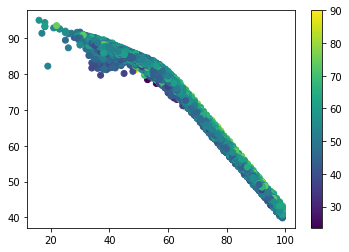

In [8]:
fig, ax = plt.subplots()


points=ax.scatter(punt_data["yd_from_goal"], punt_data["xopponent_field_position"], c=punt_data["receiving_vegas_pred"] + punt_data["kicking_vegas_pred"], alpha=1)
fig.colorbar(points)

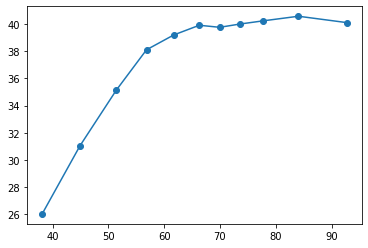

In [9]:

punt_data["xopponent_field_position_perc"] = round(punt_data["xopponent_field_position"].rank(pct=True), 1)

calb = punt_data.groupby("xopponent_field_position_perc", as_index=False).mean()
plt.plot(calb["yd_from_goal"], calb["yd_from_goal"] - (100 - calb["opponent_field_position"]), marker="o")
# plt.plot([50, 100], [50, 100])

In [10]:
normalize_df(model_df[(model_df.continuation==0)&(model_df.yd_from_goal!=-1)][input_names_punt], punt_data[punt_data["season"]<2019])

,time_left_in_half,half,current_score_diff,current_score_total,kicking_vegas_pred,receiving_vegas_pred,yd_from_goal,home_team_has_ball
2,0.985753,0.0,0.541667,0.000000,0.259259,0.396825,0.707317,1.0
3,0.985753,0.0,0.541667,0.000000,0.259259,0.396825,0.658537,1.0
4,0.961644,0.0,0.541667,0.000000,0.259259,0.396825,0.719512,1.0
5,0.936986,0.0,0.541667,0.000000,0.259259,0.396825,0.597561,1.0
6,0.925479,0.0,0.541667,0.000000,0.259259,0.396825,0.536585,1.0
...,...,...,...,...,...,...,...,...
1700030,0.023014,1.0,0.437500,0.404762,0.391534,0.455026,0.487805,1.0
1700031,0.020822,1.0,0.437500,0.404762,0.391534,0.455026,0.353659,1.0
1700034,0.018082,1.0,0.437500,0.404762,0.391534,0.455026,0.500000,1.0
1700036,0.014795,1.0,0.437500,0.404762,0.391534,0.455026,0.573171,1.0


In [11]:
punt_prediction_inputs = normalize_df(model_df[(model_df.continuation==0)&(model_df.yd_from_goal!=-1)][input_names_punt], punt_data[punt_data["season"]<2019]).dropna()
model_df["xpunt_opp_field_position"] = pd.DataFrame(mlp_punt_field_position.predict(punt_prediction_inputs), punt_prediction_inputs.index)

In [12]:
field_goal_data = model_df[(model_df["field_goal_attempt"]==1)&(model_df["play_counts"]==1)][input_names_play_and_drive_preds + ["event_name", "play_counts", "yards_gained", "season", "home_vegas_score_pred", "away_vegas_score_pred", "game_code", "nevent", "kicking_vegas_pred", "receiving_vegas_pred", "drive_outcome_desc_basic"]].reset_index(drop=True)
field_goal_data = field_goal_data.dropna()
field_goal_data["field_goal_made"] = np.where((field_goal_data["drive_outcome_desc_basic"]=="field_goal_made")&(field_goal_data["yd_from_goal"]<=45), 1, 0)


In [13]:
mlp_field_goal_made = MLPClassifier(hidden_layer_sizes=[100], verbose=True, early_stopping=True, n_iter_no_change=5, random_state=1)
input_names_field_goal = [
    'time_left_in_half',
    'half',
    'current_score_diff',
    'current_score_total',
    'kicking_vegas_pred',
    'receiving_vegas_pred',
    'yd_from_goal',
    'home_team_has_ball',    
]
X_train, y_train, group_train, X_test, y_test, group_test, X_val, y_val, group_val = create_train_test_val_df(field_goal_data, input_names_field_goal, "field_goal_made", normalize=True)
mlp_field_goal_made.fit(X_train, y_train)


field_goal_data[["xfield_goal_missed", "xfield_goal_made"]] = mlp_field_goal_made.predict_proba(pd.concat([X_train, X_val, X_test])[input_names_field_goal])

Iteration 1, loss = 0.63333494
Validation score: 0.733748
Iteration 2, loss = 0.57714581
Validation score: 0.733748
Iteration 3, loss = 0.56495887
Validation score: 0.733748
Iteration 4, loss = 0.55292095
Validation score: 0.733748
Iteration 5, loss = 0.54363710
Validation score: 0.733748
Iteration 6, loss = 0.53504345


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-

Validation score: 0.737898
Iteration 7, loss = 0.52940011
Validation score: 0.737898
Iteration 8, loss = 0.52549772
Validation score: 0.748963
Iteration 9, loss = 0.52299810
Validation score: 0.747580
Iteration 10, loss = 0.52143356
Validation score: 0.744813


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-

Iteration 11, loss = 0.52074759
Validation score: 0.746196
Iteration 12, loss = 0.52069312
Validation score: 0.744122
Iteration 13, loss = 0.52006078
Validation score: 0.744122
Iteration 14, loss = 0.51943594
Validation score: 0.749654
Iteration 15, loss = 0.51967418
Validation score: 0.742739


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-

Iteration 16, loss = 0.51974261
Validation score: 0.743430
Iteration 17, loss = 0.51984978
Validation score: 0.748271
Iteration 18, loss = 0.51952143
Validation score: 0.744813
Iteration 19, loss = 0.52107092
Validation score: 0.744122
Iteration 20, loss = 0.51987593
Validation score: 0.747580
Validation score did not improve more than tol=0.000100 for 5 consecutive epochs. Stopping.


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


In [14]:
field_goal_prediction_inputs = normalize_df(model_df[(model_df.continuation==0)&(model_df.yd_from_goal!=-1)][input_names_field_goal], field_goal_data[field_goal_data["season"]<2019]).dropna()
model_df[["xfield_goal_missed", "xfield_goal_made"]] = pd.DataFrame(mlp_field_goal_made.predict_proba(field_goal_prediction_inputs), field_goal_prediction_inputs.index)
model_df["xfield_goal_missed"] = np.where(model_df["yd_from_goal"]<=45, model_df["xfield_goal_missed"], 1)
model_df["xfield_goal_made"] = np.where(model_df["yd_from_goal"]<=45, model_df["xfield_goal_made"], 0)

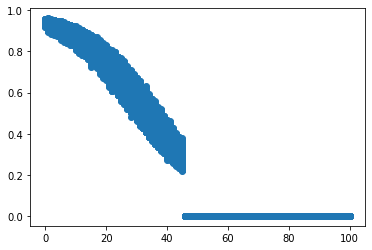

In [15]:
plt.scatter(model_df["yd_from_goal"], model_df["xfield_goal_made"])

In [16]:
model_df["yd_from_goal_round"] = round(model_df["yd_from_goal"] / 5, 0) * 5
field_goal_data["yd_from_goal_round"] = round(field_goal_data["yd_from_goal"] / 5, 0) * 5
field_goal_data.groupby(["yd_from_goal_round"]).mean()[["yd_from_goal", "field_goal_made", "xfield_goal_made"]]

,yd_from_goal,field_goal_made,xfield_goal_made
yd_from_goal_round,,,
0.0,1.677201,0.948081,0.932099
5.0,5.146071,0.930772,0.912832
10.0,9.929305,0.873716,0.875535
15.0,15.002372,0.798636,0.819333
20.0,20.024818,0.720292,0.747876
25.0,24.947633,0.625740,0.660818
30.0,29.843145,0.561717,0.560054
35.0,34.503662,0.459723,0.459723
40.0,39.047619,0.326531,0.364792


In [17]:
field_goal_data[field_goal_data["field_goal_made"] ==1][["yd_from_goal"]].sort_values("yd_from_goal")[-20:]

,yd_from_goal
4119,39
3722,39
16808,39
18217,39
16594,39
13496,39
22303,39
9140,40
22646,40
13495,40


In [18]:
go_for_it_data = model_no_continuation[(model_no_continuation["punt"] + model_no_continuation["field_goal_attempt"]==0)&(model_no_continuation["down"]==4)&(model_no_continuation["play_counts"]==1)&(model_no_continuation["event_id"].isin(scrimmage_plays_we_want))][input_names_play_and_drive_preds + ["event_name", "play_counts", "yards_gained", "season", "home_vegas_score_pred", "away_vegas_score_pred", "game_code", "nevent", "kicking_vegas_pred", "receiving_vegas_pred", "drive_outcome_desc_basic", "play_start_id", "play_outcome"]].reset_index(drop=True)
go_for_it_result = model_no_continuation[(model_no_continuation.shift(1)["punt"] + model_no_continuation.shift(1)["field_goal_attempt"]==0)&(model_no_continuation.shift(1)["down"]==4)&(model_no_continuation.shift(1)["play_counts"]==1)&(model_no_continuation.shift(1)["event_id"].isin(scrimmage_plays_we_want))][input_names_play_and_drive_preds + ["event_name", "play_counts", "yards_gained", "season", "home_vegas_score_pred", "away_vegas_score_pred", "game_code", "nevent", "play_start_id"]].reset_index(drop=True)
go_for_it_data["next_play_yd_from_goal"] = go_for_it_result["yd_from_goal"]
go_for_it_data = go_for_it_data.dropna()
go_for_it_success = go_for_it_data[go_for_it_data["play_outcome"] == "first_down"]


In [19]:
mlp_go_for_it_success_next_yds = MLPRegressor(hidden_layer_sizes=[100], verbose=True, early_stopping=True, n_iter_no_change=5, random_state=1)
input_names_go_for_it = [
    'time_left_in_half',
    'half',
    'current_score_diff',
    'current_score_total',
    'kicking_vegas_pred',
    'receiving_vegas_pred',
    'yd_from_goal',
    'ytg',
    'home_team_has_ball',    
]
X_train, y_train, group_train, X_test, y_test, group_test, X_val, y_val, group_val = create_train_test_val_df(go_for_it_success, input_names_go_for_it, "next_play_yd_from_goal")
mlp_go_for_it_success_next_yds.fit(X_train, y_train)


go_for_it_success["xnext_field_position_if_first_down"] = mlp_go_for_it_success_next_yds.predict(pd.concat([X_train, X_val, X_test])[input_names_go_for_it])



Iteration 1, loss = 144.33222993
Validation score: 0.369164
Iteration 2, loss = 88.04431422
Validation score: 0.556431
Iteration 3, loss = 62.29072999
Validation score: 0.654547
Iteration 4, loss = 50.41224656
Validation score: 0.699495
Iteration 5, loss = 45.21162504
Validation score: 0.720216
Iteration 6, loss = 40.90058579
Validation score: 0.735625
Iteration 7, loss = 39.19833729
Validation score: 0.745778
Iteration 8, loss = 38.21170948
Validation score: 0.752474
Iteration 9, loss = 37.14654336
Validation score: 0.749299
Iteration 10, loss = 36.88913532
Validation score: 0.756124
Iteration 11, loss = 36.51945784
Validation score: 0.753883
Iteration 12, loss = 36.30550146
Validation score: 0.760787
Iteration 13, loss = 36.29086722
Validation score: 0.763695


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-pack

Iteration 14, loss = 36.25920480
Validation score: 0.764525
Iteration 15, loss = 35.96318469
Validation score: 0.763878
Iteration 16, loss = 36.91837692
Validation score: 0.765534
Iteration 17, loss = 35.82592742
Validation score: 0.739093
Iteration 18, loss = 36.93049416
Validation score: 0.758668
Iteration 19, loss = 36.78881996
Validation score: 0.766057
Iteration 20, loss = 35.82177605
Validation score: 0.765299
Iteration 21, loss = 35.85301856
Validation score: 0.759831
Iteration 22, loss = 36.13632271
Validation score: 0.763176
Iteration 23, loss = 35.47630798
Validation score: 0.767399
Iteration 24, loss = 35.32123797
Validation score: 0.769365
Iteration 25, loss = 35.11454174
Validation score: 0.768429
Iteration 26, loss = 35.17809524
Validation score: 0.769510


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-pack

Iteration 27, loss = 35.98012613
Validation score: 0.769626
Iteration 28, loss = 35.36305121
Validation score: 0.767046
Iteration 29, loss = 35.02122830
Validation score: 0.771602
Iteration 30, loss = 35.44737379
Validation score: 0.767622
Iteration 31, loss = 34.89227528
Validation score: 0.770086
Iteration 32, loss = 36.51076009
Validation score: 0.765188
Iteration 33, loss = 35.36923255
Validation score: 0.765338
Iteration 34, loss = 34.91961836
Validation score: 0.770016
Iteration 35, loss = 35.20115830
Validation score: 0.756672
Validation score did not improve more than tol=0.000100 for 5 consecutive epochs. Stopping.


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-pack

In [20]:
search_rf_play_outcome = pickle.load(open(os.path.join(root_dir, "models/search_rf_play_outcome_cfb.p"), 'rb'))
search_rf_drive_outcome = pickle.load(open(os.path.join(root_dir, "models/search_rf_drive_outcome_cfb.p"), 'rb'))
search_mlp_score_diff_clipped_rf_drive_preds = pickle.load(open(os.path.join(root_dir, "models/search_mlp_score_diff_clipped_rf_drive_preds_cfb.p"), 'rb'))


/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.1.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.1.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/lucashaupt/Documents/GitHub/nfl-live-win-probability/venv/lib/python3.9/site-packages/sklearn/base.

In [21]:
search_rf_play_class_names = ["search_rf_play_" + x for x in search_rf_play_outcome.classes_]
search_rf_drive_class_names = ["search_rf_drive_" + x for x in search_rf_drive_outcome.classes_]
search_rf_play_class_names_home = [x + "_home" for x in search_rf_play_class_names]
search_rf_play_class_names_away = [x + "_away" for x in search_rf_play_class_names]
search_rf_drive_class_names_home = [x + "_home" for x in search_rf_drive_class_names]
search_rf_drive_class_names_away = [x + "_away" for x in search_rf_drive_class_names]
mask_model_drive_play = (
    (model_df.continuation==0)&
    (model_df.down!=0)&
    (model_df["from_scrimmage"]==1)&
    (model_df["overtime"]==0)
)
search_rf_play_outcome.best_estimator_.verbose=0
search_rf_drive_outcome.best_estimator_.verbose=0


fourth_down_data = model_df[
    (model_df["down"] == 4)&
    (model_df[input_names_score_diff_pred].notna().all(axis=1))
]
fourth_down_data = fourth_down_data[fourth_down_data[input_names_play_and_drive_preds].notna().all(axis=1)]

fourth_down_data["xnext_field_position_if_first_down"] = mlp_go_for_it_success_next_yds.predict(fourth_down_data[input_names_go_for_it])
fourth_down_data[fourth_down_data["xnext_field_position_if_first_down"].isna()]
fourth_down_data[input_names_play_and_drive_preds].notna().all(axis=1)


13         True
20         True
42         True
62         True
76         True
           ... 
1699930    True
1699948    True
1699969    True
1699999    True
1700037    True
Length: 115072, dtype: bool

In [22]:
fourth_down_go_for_it_success_data = deepcopy(fourth_down_data)
fourth_down_go_for_it_success_data["event_name"].value_counts()


fourth_down_go_for_it_success_data["current_score_diff"] = np.where(
    (fourth_down_data["ytg"]>=fourth_down_data["yd_from_goal"])| (fourth_down_data["xnext_field_position_if_first_down"] <=.5), 
    (2  * fourth_down_data["home_team_has_ball"] - 1) * 6 + fourth_down_data["current_score_diff"],
    fourth_down_data["current_score_diff"]
)
fourth_down_go_for_it_success_data["current_score_total"] = np.where(
    (fourth_down_data["ytg"]>=fourth_down_data["yd_from_goal"])| (fourth_down_data["xnext_field_position_if_first_down"] <=.5), 
    6 + fourth_down_data["current_score_total"],
    fourth_down_data["current_score_total"]
)
fourth_down_go_for_it_success_data["ytg"] = np.where(
    (fourth_down_data["ytg"]>=fourth_down_data["yd_from_goal"])| (fourth_down_data["xnext_field_position_if_first_down"] <=.5), 
    -1, 10
)
fourth_down_go_for_it_success_data["yd_from_goal"] = np.where(
    (fourth_down_data["ytg"]>=fourth_down_data["yd_from_goal"])| (fourth_down_data["xnext_field_position_if_first_down"] <=.5), 
    -1, fourth_down_data["xnext_field_position_if_first_down"].fillna(fourth_down_data["yd_from_goal"] - fourth_down_data["ytg"])
)
fourth_down_go_for_it_success_data["down"] = np.where(
    (fourth_down_data["ytg"]>=fourth_down_data["yd_from_goal"])| (fourth_down_data["xnext_field_position_if_first_down"] <=.5), 
    0, 1
)
fourth_down_go_for_it_success_data["point_after_play"] = np.where(
    (fourth_down_data["ytg"]>=fourth_down_data["yd_from_goal"])| (fourth_down_data["xnext_field_position_if_first_down"] <=.5), 
    1, 0
)
# fourth_down_go_for_it_success_data[search_rf_play_class_names] = np.where(
#     (fourth_down_data["ytg"]>=fourth_down_data["yd_from_goal"])| (fourth_down_data["xnext_field_position_if_first_down"] <=.5), 
#     search_rf_play_outcome.predict_proba(fourth_down_go_for_it_success_data[input_names_play_and_drive_preds]), [0, 0, 0, 0, 0, 0, 0]
# )
fourth_down_go_for_it_success_data[search_rf_play_class_names] = pd.DataFrame(search_rf_play_outcome.predict_proba(fourth_down_go_for_it_success_data[fourth_down_go_for_it_success_data.down!=0][input_names_play_and_drive_preds]), fourth_down_go_for_it_success_data[fourth_down_go_for_it_success_data.down!=0].index)
fourth_down_go_for_it_success_data[search_rf_play_class_names] = fourth_down_go_for_it_success_data[search_rf_play_class_names].fillna(0)
fourth_down_go_for_it_success_data[search_rf_drive_class_names] = pd.DataFrame(search_rf_drive_outcome.predict_proba(fourth_down_go_for_it_success_data[fourth_down_go_for_it_success_data.down!=0][input_names_play_and_drive_preds]), fourth_down_go_for_it_success_data[fourth_down_go_for_it_success_data.down!=0].index)
fourth_down_go_for_it_success_data[search_rf_drive_class_names] = fourth_down_go_for_it_success_data[search_rf_drive_class_names].fillna(0)
fourth_down_go_for_it_fail_data = deepcopy(fourth_down_data)
fourth_down_go_for_it_fail_data["event_name"].value_counts()


fourth_down_go_for_it_fail_data["yd_from_goal"] = 100 - fourth_down_data["yd_from_goal"]
fourth_down_go_for_it_fail_data["ytg"] = np.where(fourth_down_go_for_it_fail_data["yd_from_goal"] <=10, fourth_down_go_for_it_fail_data["yd_from_goal"], 10)
fourth_down_go_for_it_fail_data["down"] = 1
fourth_down_go_for_it_fail_data["home_team_has_ball"] = 1 - fourth_down_data["home_team_has_ball"]

# fourth_down_go_for_it_fail_data[search_rf_play_class_names] = np.where(
#     (fourth_down_data["ytg"]>=fourth_down_data["yd_from_goal"])| (fourth_down_data["xnext_field_position_if_first_down"] <=.5), 
#     search_rf_play_outcome.predict_proba(fourth_down_go_for_it_fail_data[input_names_play_and_drive_preds]), [0, 0, 0, 0, 0, 0, 0]
# )
fourth_down_go_for_it_fail_data[search_rf_play_class_names] = pd.DataFrame(search_rf_play_outcome.predict_proba(fourth_down_go_for_it_fail_data[fourth_down_go_for_it_fail_data.down!=0][input_names_play_and_drive_preds]), fourth_down_go_for_it_fail_data[fourth_down_go_for_it_fail_data.down!=0].index)
fourth_down_go_for_it_fail_data[search_rf_play_class_names] = fourth_down_go_for_it_fail_data[search_rf_play_class_names].fillna(0)
fourth_down_go_for_it_fail_data[search_rf_drive_class_names] = pd.DataFrame(search_rf_drive_outcome.predict_proba(fourth_down_go_for_it_fail_data[fourth_down_go_for_it_fail_data.down!=0][input_names_play_and_drive_preds]), fourth_down_go_for_it_fail_data[fourth_down_go_for_it_fail_data.down!=0].index)
fourth_down_go_for_it_fail_data[search_rf_drive_class_names] = fourth_down_go_for_it_fail_data[search_rf_drive_class_names].fillna(0)


In [23]:
fourth_down_go_for_it_success_data = deepcopy(fourth_down_data)
fourth_down_go_for_it_success_data["event_name"].value_counts()


fourth_down_go_for_it_success_data["current_score_diff"] = np.where(
    (fourth_down_data["ytg"]>=fourth_down_data["yd_from_goal"])| (fourth_down_data["xnext_field_position_if_first_down"] <=.5), 
    (2  * fourth_down_data["home_team_has_ball"] - 1) * 6 + fourth_down_data["current_score_diff"],
    fourth_down_data["current_score_diff"]
)
fourth_down_go_for_it_success_data["current_score_total"] = np.where(
    (fourth_down_data["ytg"]>=fourth_down_data["yd_from_goal"])| (fourth_down_data["xnext_field_position_if_first_down"] <=.5), 
    6 + fourth_down_data["current_score_total"],
    fourth_down_data["current_score_total"]
)
fourth_down_go_for_it_success_data["ytg"] = np.where(
    (fourth_down_data["ytg"]>=fourth_down_data["yd_from_goal"])| (fourth_down_data["xnext_field_position_if_first_down"] <=.5), 
    -1, 10
)
fourth_down_go_for_it_success_data["yd_from_goal"] = np.where(
    (fourth_down_data["ytg"]>=fourth_down_data["yd_from_goal"])| (fourth_down_data["xnext_field_position_if_first_down"] <=.5), 
    -1, fourth_down_data["xnext_field_position_if_first_down"].fillna(fourth_down_data["yd_from_goal"] - fourth_down_data["ytg"])
)
fourth_down_go_for_it_success_data["down"] = np.where(
    (fourth_down_data["ytg"]>=fourth_down_data["yd_from_goal"])| (fourth_down_data["xnext_field_position_if_first_down"] <=.5), 
    0, 1
)
fourth_down_go_for_it_success_data["point_after_play"] = np.where(
    (fourth_down_data["ytg"]>=fourth_down_data["yd_from_goal"])| (fourth_down_data["xnext_field_position_if_first_down"] <=.5), 
    1, 0
)
# fourth_down_go_for_it_success_data[search_rf_play_class_names] = np.where(
#     (fourth_down_data["ytg"]>=fourth_down_data["yd_from_goal"])| (fourth_down_data["xnext_field_position_if_first_down"] <=.5), 
#     search_rf_play_outcome.predict_proba(fourth_down_go_for_it_success_data[input_names_play_and_drive_preds]), [0, 0, 0, 0, 0, 0, 0]
# )
fourth_down_go_for_it_success_data[search_rf_play_class_names] = pd.DataFrame(search_rf_play_outcome.predict_proba(fourth_down_go_for_it_success_data[fourth_down_go_for_it_success_data.down!=0][input_names_play_and_drive_preds]), fourth_down_go_for_it_success_data[fourth_down_go_for_it_success_data.down!=0].index)
fourth_down_go_for_it_success_data[search_rf_play_class_names] = fourth_down_go_for_it_success_data[search_rf_play_class_names].fillna(0)
fourth_down_go_for_it_success_data[search_rf_play_class_names_home] = fourth_down_go_for_it_success_data[search_rf_play_class_names].where(fourth_down_go_for_it_success_data["home_team_has_ball"]==1, 0)
fourth_down_go_for_it_success_data[search_rf_play_class_names_away] = fourth_down_go_for_it_success_data[search_rf_play_class_names].where(fourth_down_go_for_it_success_data["home_team_has_ball"]==0, 0)

fourth_down_go_for_it_success_data[search_rf_drive_class_names] = pd.DataFrame(search_rf_drive_outcome.predict_proba(fourth_down_go_for_it_success_data[fourth_down_go_for_it_success_data.down!=0][input_names_play_and_drive_preds]), fourth_down_go_for_it_success_data[fourth_down_go_for_it_success_data.down!=0].index)
fourth_down_go_for_it_success_data[search_rf_drive_class_names] = fourth_down_go_for_it_success_data[search_rf_drive_class_names].fillna(0)
fourth_down_go_for_it_success_data[search_rf_drive_class_names_home] = fourth_down_go_for_it_success_data[search_rf_drive_class_names].where(fourth_down_go_for_it_success_data["home_team_has_ball"]==1, 0)
fourth_down_go_for_it_success_data[search_rf_drive_class_names_away] = fourth_down_go_for_it_success_data[search_rf_drive_class_names].where(fourth_down_go_for_it_success_data["home_team_has_ball"]==0, 0)




fourth_down_go_for_it_fail_data = deepcopy(fourth_down_data)
fourth_down_go_for_it_fail_data["event_name"].value_counts()


fourth_down_go_for_it_fail_data["yd_from_goal"] = 100 - fourth_down_data["yd_from_goal"]
fourth_down_go_for_it_fail_data["ytg"] = np.where(fourth_down_go_for_it_fail_data["yd_from_goal"] <=10, fourth_down_go_for_it_fail_data["yd_from_goal"], 10)
fourth_down_go_for_it_fail_data["down"] = 1
fourth_down_go_for_it_fail_data["home_team_has_ball"] = 1 - fourth_down_data["home_team_has_ball"]

# fourth_down_go_for_it_fail_data[search_rf_play_class_names] = np.where(
#     (fourth_down_data["ytg"]>=fourth_down_data["yd_from_goal"])| (fourth_down_data["xnext_field_position_if_first_down"] <=.5), 
#     search_rf_play_outcome.predict_proba(fourth_down_go_for_it_fail_data[input_names_play_and_drive_preds]), [0, 0, 0, 0, 0, 0, 0]
# )
fourth_down_go_for_it_fail_data[search_rf_play_class_names] = pd.DataFrame(search_rf_play_outcome.predict_proba(fourth_down_go_for_it_fail_data[fourth_down_go_for_it_fail_data.down!=0][input_names_play_and_drive_preds]), fourth_down_go_for_it_fail_data[fourth_down_go_for_it_fail_data.down!=0].index)
fourth_down_go_for_it_fail_data[search_rf_play_class_names] = fourth_down_go_for_it_fail_data[search_rf_play_class_names].fillna(0)
fourth_down_go_for_it_fail_data[search_rf_play_class_names_home] = fourth_down_go_for_it_fail_data[search_rf_play_class_names].where(fourth_down_go_for_it_fail_data["home_team_has_ball"]==1, 0)
fourth_down_go_for_it_fail_data[search_rf_play_class_names_away] = fourth_down_go_for_it_fail_data[search_rf_play_class_names].where(fourth_down_go_for_it_fail_data["home_team_has_ball"]==0, 0)

fourth_down_go_for_it_fail_data[search_rf_drive_class_names] = pd.DataFrame(search_rf_drive_outcome.predict_proba(fourth_down_go_for_it_fail_data[fourth_down_go_for_it_fail_data.down!=0][input_names_play_and_drive_preds]), fourth_down_go_for_it_fail_data[fourth_down_go_for_it_fail_data.down!=0].index)
fourth_down_go_for_it_fail_data[search_rf_drive_class_names] = fourth_down_go_for_it_fail_data[search_rf_drive_class_names].fillna(0)
fourth_down_go_for_it_fail_data[search_rf_drive_class_names_home] = fourth_down_go_for_it_fail_data[search_rf_drive_class_names].where(fourth_down_go_for_it_fail_data["home_team_has_ball"]==1, 0)
fourth_down_go_for_it_fail_data[search_rf_drive_class_names_away] = fourth_down_go_for_it_fail_data[search_rf_drive_class_names].where(fourth_down_go_for_it_fail_data["home_team_has_ball"]==0, 0)



In [191]:
fourth_down_field_goal_success_data = deepcopy(fourth_down_data)
fourth_down_field_goal_success_data["event_name"].value_counts()


fourth_down_field_goal_success_data["current_score_diff"] = (2  * fourth_down_data["home_team_has_ball"] - 1) * 3 + fourth_down_data["current_score_diff"]
fourth_down_field_goal_success_data["current_score_total"] = 3 + fourth_down_data["current_score_total"]
fourth_down_field_goal_success_data["ytg"] = -1
fourth_down_field_goal_success_data["yd_from_goal"] = -1
fourth_down_field_goal_success_data["down"] = 0
fourth_down_field_goal_success_data["home_team_has_ball"] = 1 - fourth_down_data["home_team_has_ball"]
fourth_down_field_goal_success_data["kick_off"] = 1
# fourth_down_field_goal_success_data[search_rf_play_class_names] = np.where(
#     (fourth_down_data["ytg"]>=fourth_down_data["yd_from_goal"])| (fourth_down_data["xnext_field_position_if_first_down"] <=.5), 
#     search_rf_play_outcome.predict_proba(fourth_down_field_goal_success_data[input_names_play_and_drive_preds]), [0, 0, 0, 0, 0, 0, 0]
# )
fourth_down_field_goal_success_data[search_rf_play_class_names_away] = 0
fourth_down_field_goal_success_data[search_rf_play_class_names_home] = 0
fourth_down_field_goal_success_data[search_rf_drive_class_names_away] = 0
fourth_down_field_goal_success_data[search_rf_drive_class_names_home] = 0
fourth_down_field_goal_fail_data = deepcopy(fourth_down_data)


# fourth_down_field_goal_fail_data["yd_from_goal"] = 100 - (fourth_down_data["yd_from_goal"] + 7)
fourth_down_field_goal_fail_data["yd_from_goal"] = np.where(fourth_down_data["yd_from_goal"]>=20, 100 - (fourth_down_data["yd_from_goal"]), 80)
fourth_down_field_goal_fail_data["ytg"] = np.where(fourth_down_field_goal_fail_data["yd_from_goal"] <=10, fourth_down_field_goal_fail_data["yd_from_goal"], 10)
fourth_down_field_goal_fail_data["down"] = 1
fourth_down_field_goal_fail_data["home_team_has_ball"] = 1 - fourth_down_data["home_team_has_ball"]

# fourth_down_field_goal_fail_data[search_rf_play_class_names] = np.where(
#     (fourth_down_data["ytg"]>=fourth_down_data["yd_from_goal"])| (fourth_down_data["xnext_field_position_if_first_down"] <=.5), 
#     search_rf_play_outcome.predict_proba(fourth_down_field_goal_fail_data[input_names_play_and_drive_preds]), [0, 0, 0, 0, 0, 0, 0]
# )
fourth_down_field_goal_fail_data[search_rf_play_class_names] = pd.DataFrame(search_rf_play_outcome.predict_proba(fourth_down_field_goal_fail_data[fourth_down_field_goal_fail_data.down!=0][input_names_play_and_drive_preds]), fourth_down_field_goal_fail_data[fourth_down_field_goal_fail_data.down!=0].index)
fourth_down_field_goal_fail_data[search_rf_play_class_names] = fourth_down_field_goal_fail_data[search_rf_play_class_names].fillna(0)
fourth_down_field_goal_fail_data[search_rf_play_class_names_home] = fourth_down_field_goal_fail_data[search_rf_play_class_names].where(fourth_down_field_goal_fail_data["home_team_has_ball"]==1, 0)
fourth_down_field_goal_fail_data[search_rf_play_class_names_away] = fourth_down_field_goal_fail_data[search_rf_play_class_names].where(fourth_down_field_goal_fail_data["home_team_has_ball"]==0, 0)

fourth_down_field_goal_fail_data[search_rf_drive_class_names] = pd.DataFrame(search_rf_drive_outcome.predict_proba(fourth_down_field_goal_fail_data[fourth_down_field_goal_fail_data.down!=0][input_names_play_and_drive_preds]), fourth_down_field_goal_fail_data[fourth_down_field_goal_fail_data.down!=0].index)
fourth_down_field_goal_fail_data[search_rf_drive_class_names] = fourth_down_field_goal_fail_data[search_rf_drive_class_names].fillna(0)
fourth_down_field_goal_fail_data[search_rf_drive_class_names_home] = fourth_down_field_goal_fail_data[search_rf_drive_class_names].where(fourth_down_field_goal_fail_data["home_team_has_ball"]==1, 0)
fourth_down_field_goal_fail_data[search_rf_drive_class_names_away] = fourth_down_field_goal_fail_data[search_rf_drive_class_names].where(fourth_down_field_goal_fail_data["home_team_has_ball"]==0, 0)




In [192]:
fourth_down_punt_data = deepcopy(fourth_down_data)
fourth_down_punt_data["yd_from_goal"] = fourth_down_data["xpunt_opp_field_position"].fillna(80)
fourth_down_punt_data["ytg"] = np.where(fourth_down_punt_data["yd_from_goal"] <=10, fourth_down_punt_data["yd_from_goal"], 10)
fourth_down_punt_data["down"] = 1
fourth_down_punt_data["home_team_has_ball"] = 1 - fourth_down_data["home_team_has_ball"]

# fourth_down_punt_data[search_rf_play_class_names] = np.where(
#     (fourth_down_data["ytg"]>=fourth_down_data["yd_from_goal"])| (fourth_down_data["xnext_field_position_if_first_down"] <=.5), 
#     search_rf_play_outcome.predict_proba(fourth_down_punt_data[input_names_play_and_drive_preds]), [0, 0, 0, 0, 0, 0, 0]
# )
fourth_down_punt_data[search_rf_play_class_names] = pd.DataFrame(search_rf_play_outcome.predict_proba(fourth_down_punt_data[fourth_down_punt_data.down!=0][input_names_play_and_drive_preds]), fourth_down_punt_data[fourth_down_punt_data.down!=0].index)
fourth_down_punt_data[search_rf_play_class_names] = fourth_down_punt_data[search_rf_play_class_names].fillna(0)
fourth_down_punt_data[search_rf_play_class_names_home] = fourth_down_punt_data[search_rf_play_class_names].where(fourth_down_punt_data["home_team_has_ball"]==1, 0)
fourth_down_punt_data[search_rf_play_class_names_away] = fourth_down_punt_data[search_rf_play_class_names].where(fourth_down_punt_data["home_team_has_ball"]==0, 0)

fourth_down_punt_data[search_rf_drive_class_names] = pd.DataFrame(search_rf_drive_outcome.predict_proba(fourth_down_punt_data[fourth_down_punt_data.down!=0][input_names_play_and_drive_preds]), fourth_down_punt_data[fourth_down_punt_data.down!=0].index)
fourth_down_punt_data[search_rf_drive_class_names] = fourth_down_punt_data[search_rf_drive_class_names].fillna(0)
fourth_down_punt_data[search_rf_drive_class_names_home] = fourth_down_punt_data[search_rf_drive_class_names].where(fourth_down_punt_data["home_team_has_ball"]==1, 0)
fourth_down_punt_data[search_rf_drive_class_names_away] = fourth_down_punt_data[search_rf_drive_class_names].where(fourth_down_punt_data["home_team_has_ball"]==0, 0)




In [193]:
mask_model

0           True
1          False
2           True
3           True
4           True
           ...  
1700034     True
1700035    False
1700036     True
1700037     True
1700038    False
Length: 1700039, dtype: bool

In [194]:
mask_model = (
    (model_df.continuation==0)&
    (model_df[input_names_score_diff_pred].notna().all(axis=1))&
    ~(model_df.event_id.isin([12,57,58,13]))&
    (model_df["overtime"]==0)
)

anchor_df = model_df[mask_model&(model_df.season<2019)]


score_diff_change_list_clipped = list(model_df.end_of_regulation_score_diff_change_clipped.drop_duplicates().sort_values())
score_diff_clipped_mlp_drive_preds_matrix = pd.DataFrame(np.zeros((len(fourth_down_data), len(score_diff_change_list_clipped))), index=fourth_down_data.index)


for column in score_diff_clipped_mlp_drive_preds_matrix.columns:
    score_diff_clipped_mlp_drive_preds_matrix[column] = score_diff_change_list_clipped[column] + fourth_down_data["current_score_diff"]


normalized_data_dicts = {}
predictions_dicts = {}
win_prob_dict = {}
for outcome in ["fourth_down_go_for_it_success_data", "fourth_down_go_for_it_fail_data", "fourth_down_field_goal_success_data", "fourth_down_field_goal_fail_data", "fourth_down_punt_data"]:
    print(outcome)
    normalized_data_dicts[outcome + "_normalized"] = normalize_df(eval(outcome)[input_names_score_diff_pred], anchor_df)
    predictions_dicts[outcome] = pd.DataFrame(search_mlp_score_diff_clipped_rf_drive_preds.predict_proba(normalized_data_dicts[outcome + "_normalized"]), normalized_data_dicts[outcome + "_normalized"].index)
    score_diff_clipped_mlp_drive_preds_matrix = pd.DataFrame(np.zeros((len(fourth_down_data), len(score_diff_change_list_clipped))), index=fourth_down_data.index)
    for column in score_diff_clipped_mlp_drive_preds_matrix.columns:
        score_diff_clipped_mlp_drive_preds_matrix[column] = score_diff_change_list_clipped[column] + eval(outcome)["current_score_diff"]
    win_prob_dict[outcome] = pd.DataFrame()
    win_prob_dict[outcome]["xhome_win_mlp_search_clipped_mlp_drive_preds"] = np.sum(predictions_dicts[outcome].T[score_diff_clipped_mlp_drive_preds_matrix.T>0], axis=0)
    win_prob_dict[outcome]["xovertime_mlp_search_clipped_mlp_drive_preds"] = np.sum(predictions_dicts[outcome].T[score_diff_clipped_mlp_drive_preds_matrix.T==0], axis=0)
    win_prob_dict[outcome]["xaway_win_mlp_search_clipped_mlp_drive_preds"] = np.sum(predictions_dicts[outcome].T[score_diff_clipped_mlp_drive_preds_matrix.T<0], axis=0)
    score_diff_clipped_mlp_drive_preds_matrix.to_csv(outcome + "score_diff_clipped_mlp_drive_preds_matrix.csv")


fourth_down_go_for_it_success_data


/var/folders/dq/tcxv3s4j7y585_4jhfbdvrx00000gn/T/ipykernel_3095/3369424538.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = (data - np.min(anchor_df[col])) / (np.max(anchor_df[col]) - np.min(anchor_df[col]))


fourth_down_go_for_it_fail_data


/var/folders/dq/tcxv3s4j7y585_4jhfbdvrx00000gn/T/ipykernel_3095/3369424538.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = (data - np.min(anchor_df[col])) / (np.max(anchor_df[col]) - np.min(anchor_df[col]))


fourth_down_field_goal_success_data


/var/folders/dq/tcxv3s4j7y585_4jhfbdvrx00000gn/T/ipykernel_3095/3369424538.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = (data - np.min(anchor_df[col])) / (np.max(anchor_df[col]) - np.min(anchor_df[col]))


fourth_down_field_goal_fail_data


/var/folders/dq/tcxv3s4j7y585_4jhfbdvrx00000gn/T/ipykernel_3095/3369424538.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = (data - np.min(anchor_df[col])) / (np.max(anchor_df[col]) - np.min(anchor_df[col]))


fourth_down_punt_data


/var/folders/dq/tcxv3s4j7y585_4jhfbdvrx00000gn/T/ipykernel_3095/3369424538.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = (data - np.min(anchor_df[col])) / (np.max(anchor_df[col]) - np.min(anchor_df[col]))


In [195]:
outcome_list = []
for outcome in ["fourth_down_go_for_it_success_data", "fourth_down_go_for_it_fail_data", "fourth_down_field_goal_success_data", "fourth_down_field_goal_fail_data", "fourth_down_punt_data"]:
    fourth_down_data[[outcome + x for x in["_home_win", "_overtime", "_away_win"]]] = win_prob_dict[outcome]
    outcome_list = outcome_list + [outcome + x for x in["_home_win", "_overtime", "_away_win"]]

In [196]:
# success_df = pd.DataFrame()
# success_df["go_for_it"] = fourth_down_data["search_rf_"]

In [197]:
# normalized_score_pred_df = normalize_df(model_df[mask_model][input_names_score_diff_pred], model_df[mask_model & (model_df.season<2020)])

# mlp_search_score_diff_clipped_mlp_drive_preds_preds = pd.DataFrame(search_mlp_score_diff_clipped_rf_drive_preds.predict_proba(normalized_score_pred_df), index=model_df[mask_model].index)
# score_diff_clipped_mlp_drive_preds_matrix = pd.DataFrame(np.zeros(mlp_search_score_diff_clipped_mlp_drive_preds_preds.shape), index=mlp_search_score_diff_clipped_mlp_drive_preds_preds.index)

# for column in score_diff_clipped_mlp_drive_preds_matrix.columns:
#     score_diff_clipped_mlp_drive_preds_matrix[column] = score_diff_change_list_clipped[column] + model_df["current_score_diff"]

# model_df["xhome_win_mlp_search_clipped_mlp_drive_preds"] = np.sum(mlp_search_score_diff_clipped_mlp_drive_preds_preds.T[score_diff_clipped_mlp_drive_preds_matrix.T>0], axis=0)
# model_df["xovertime_mlp_search_clipped_mlp_drive_preds"] = np.sum(mlp_search_score_diff_clipped_mlp_drive_preds_preds.T[score_diff_clipped_mlp_drive_preds_matrix.T==0], axis=0)
# model_df["xaway_win_mlp_search_clipped_mlp_drive_preds"] = np.sum(mlp_search_score_diff_clipped_mlp_drive_preds_preds.T[score_diff_clipped_mlp_drive_preds_matrix.T<0], axis=0)
# model_df["xend_of_regulation_score_diff_mlp_search_clipped_mlp_drive_preds"] = np.sum(score_diff_clipped_mlp_drive_preds_matrix * mlp_search_score_diff_clipped_mlp_drive_preds_preds, axis=1)



In [198]:
fourth_down_success_rates = pd.DataFrame()
fourth_down_success_rates["go_for_it"] = (np.sum(fourth_down_data[["search_mlp_play_first_down", "search_mlp_play_offensive_touchdown"]], axis=1) / np.sum(fourth_down_data[["search_mlp_play_first_down", "search_mlp_play_offensive_touchdown", "search_mlp_play_turnover", "search_mlp_play_none"]], axis=1) )
fourth_down_success_rates["field_goal"] = fourth_down_data["xfield_goal_made"]



In [199]:
fourth_down_data[["go_for_it_success", "field_goal_success"]] = fourth_down_success_rates[["go_for_it", "field_goal"]]
fourth_down_data["punt_success"] = np.nan

In [200]:
outcome_list_team_with_ball =[
    'fourth_down_go_for_it_success_data_win',
    'fourth_down_go_for_it_fail_data_win',
    'fourth_down_field_goal_success_data_win',
    'fourth_down_field_goal_fail_data_win',
    'fourth_down_punt_data_win'
]
outcome_list_home =[
    'fourth_down_go_for_it_success_data_home_win',
    'fourth_down_go_for_it_fail_data_home_win',
    'fourth_down_field_goal_success_data_home_win',
    'fourth_down_field_goal_fail_data_home_win',
    'fourth_down_punt_data_home_win'
]
outcome_list_away =[
    'fourth_down_go_for_it_success_data_away_win',
    'fourth_down_go_for_it_fail_data_away_win',
    'fourth_down_field_goal_success_data_away_win',
    'fourth_down_field_goal_fail_data_away_win',
    'fourth_down_punt_data_away_win'
]


for x in range(len(outcome_list_team_with_ball)):
    fourth_down_data[outcome_list_team_with_ball[x]] = np.where(fourth_down_data["home_team_has_ball"] == 1, fourth_down_data[outcome_list_home[x]], fourth_down_data[outcome_list_away[x]]) / (fourth_down_data[outcome_list_home[x]] + fourth_down_data[outcome_list_away[x]])


In [201]:
fourth_down_data["x_win_go_for_it"] = fourth_down_data["fourth_down_go_for_it_success_data_win"] * fourth_down_success_rates["go_for_it"] + fourth_down_data["fourth_down_go_for_it_fail_data_win"] * (1-fourth_down_success_rates["go_for_it"])
fourth_down_data["x_win_field_goal"] = fourth_down_data["fourth_down_field_goal_success_data_win"] * fourth_down_success_rates["field_goal"] + fourth_down_data["fourth_down_field_goal_fail_data_win"] * (1-fourth_down_success_rates["field_goal"])
fourth_down_data["x_win_punt"]  = fourth_down_data["fourth_down_punt_data_win"]


In [202]:
# test = fourth_down_data[input_names_go_for_it+["x_win_go_for_it", "x_win_field_goal", "x_win_punt"]]
# test["go_for_it_over_punt"] = test["x_win_go_for_it"] - test["x_win_punt"]
# test["go_for_it_over_field_goal"] = test["x_win_go_for_it"] - test["x_win_field_goal"]
# test["field_goal_over_punt"] = test["x_win_field_goal"] - test["x_win_punt"]
# test.to_clipboard()

In [203]:
from IPython.display import display_html, display
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
from itertools import chain,cycle


game_event_dict = {}
for game in list(fourth_down_data.sort_values("game_date", ascending=False)["game_info"].drop_duplicates()):
    game_event_dict[game] = fourth_down_data[fourth_down_data["game_info"] == game]["play_description"]


In [204]:
game_event_dict_sample = {"Alabama Crimson Tide Georgia Bulldogs 2022-01-10 2021 (2405840)": game_event_dict["Alabama Crimson Tide Georgia Bulldogs 2022-01-10 2021 (2405840)"]}
game_event_dict_sample = game_event_dict

style = {'description_width': '50px'}
layout = Layout(width='1000px')
geoWs = {key: widgets.Select(options=game_event_dict_sample[key], style=style, layout=layout) for key in game_event_dict_sample}


In [205]:
play_desc = "1st Qtr 9:58, Tied, 4th & 5, 19 Yards From Goal, Alabama Crimson Tide has ball, Off TO: 3, Def TO: 3 (16)"
play_df = fourth_down_data.loc[fourth_down_data.play_description==play_desc]
output_df = pd.DataFrame()
# output_df["Win%"] = play_df[["x_win_go_for_it", "x_win_field_goal", "x_win_punt"]].values[0]
# output_df["Success%"] = play_df[["go_for_it_success", "field_goal_success", "punt_success"]].values[0]
# # output_df["Win%"] = pd.concat([output_df, pd.DataFrame(play_df[["x_win_go_for_it", "x_win_field_goal", "x_win_punt"]].values, columns=["Win"])], axis=1)
# # output_df = pd.concat([output_df, pd.DataFrame(play_df[["go_for_it_success", "field_goal_success", "punt_success"]].values, columns=["Success"])], axis=1)

# pd.DataFrame(play_df[["go_for_it_success", "field_goal_success", "punt_success"]].values)
output_df["Win %"] = play_df[["x_win_go_for_it", "x_win_field_goal", "x_win_punt"]].values[0]
output_df["Success %"] = play_df[["go_for_it_success", "field_goal_success", "punt_success"]].values[0]
conditional_df = pd.DataFrame()
conditional_df["Success"] = play_df[["fourth_down_go_for_it_success_data_win", "fourth_down_field_goal_success_data_win", "punt_success"]].values[0]
conditional_df["Fail"] = play_df[["fourth_down_go_for_it_fail_data_win", "fourth_down_field_goal_fail_data_win", "punt_success"]].values[0]
# output_df.loc["Field Goal Attempt"] = np.where(play_df["yd_from_goal"]>=55, None, output_df.loc["Field Goal Attempt"])
output_df = pd.concat([output_df.T, conditional_df.T], keys=["", "Win % if"])
output_df = output_df.rename(columns={0: "Go For it", 1: "Field Goal Attempt", 2: "Punt"})
output_df["Punt"] = np.where(play_df["yd_from_goal"]<=30, np.nan, output_df["Punt"])


In [206]:
play_df[input_names_play_and_drive_preds]

,time_left_in_half,half,current_score_diff,current_score_total,cur_spread,cur_over_under,home_timeouts_remaining,away_timeouts_remaining,ytg,yd_from_goal,down,home_team_has_ball
1699816,1498.0,1.0,0,0,3.0,53.0,3,3,5,19,4,1


In [207]:
def get_current_play():
    return {'game': i.children[0].value,
            'play': i.children[1].value}

def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2>{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

def print_play(**func_kwargs):
    # print('func_kwargs', func_kwargs)
    # print('i.kwargs', i.kwargs)
    # print('get_current_play', get_current_play())
    print(func_kwargs["play"])
    output_df = pd.DataFrame()
    play_df = fourth_down_data.loc[fourth_down_data["play_description"]== func_kwargs["play"]]
    print(play_df["event_name"].values[0], "for", int(play_df["yards_gained"].values[0]), "yards")
    print(abs(play_df["cur_spread"].values[0]), "Point", np.where((play_df["home_team_has_ball"] * 2 - 1) * play_df["cur_spread"].values[0]>0, "Underdogs", "favorites")[0])
    output_df["Win %"] = play_df[["x_win_go_for_it", "x_win_field_goal", "x_win_punt"]].values[0].round(3) * 100
    output_df["Success %"] = play_df[["go_for_it_success", "field_goal_success", "punt_success"]].values[0].round(3) * 100
    output_df.loc[2] = np.where(play_df["yd_from_goal"]<=30, np.nan, output_df.loc[2])
    output_df = output_df.sort_values("Win %", ascending=False)
    conditional_df = pd.DataFrame()
    conditional_df["Fail"] = play_df[["fourth_down_go_for_it_fail_data_win", "fourth_down_field_goal_fail_data_win", "punt_success"]].values[0].round(3) * 100
    conditional_df["Success"] = play_df[["fourth_down_go_for_it_success_data_win", "fourth_down_field_goal_success_data_win", "punt_success"]].values[0].round(3) * 100
    # output_df.loc["Field Goal Attempt"] = np.where(play_df["yd_from_goal"]>=55, None, output_df.loc["Field Goal Attempt"])
    output_df = pd.concat([output_df.T, conditional_df.T], keys=["", "Win % if"])
    output_df = output_df.rename(columns={0: "Go For it", 1: "Field Goal Attempt", 2: "Punt"})
    # output_df = output_df.T
    # output_df = output_df.sort_values("Win %", ascending=False)
    display_html(output_df.T)


    return

def select_game(game):
    new_i = widgets.interactive(print_play, game=gameW, play=geoWs[game['new']])
    i.children = new_i.children

gameW = widgets.Dropdown(options=list(game_event_dict_sample), style=style, layout=layout)
init = gameW.value
playW = geoWs[init]

gameW.observe(select_game, 'value')

i = widgets.interactive(print_play, game=gameW, play=playW)

display(i)


interactive(children=(Dropdown(description='game', layout=Layout(width='1000px'), options=('Alabama Crimson Ti…

In [208]:
test

,time_left_in_half,half,current_score_diff,current_score_total,cur_spread,cur_over_under,home_timeouts_remaining,away_timeouts_remaining,ytg,yd_from_goal,down,home_team_has_ball
1698283,1383.0,1.0,-7,7,-20,60,3,2,4,41,4,1


In [209]:
'fourth_down_go_for_it_success_data_win',
'fourth_down_go_for_it_fail_data_win',
'fourth_down_field_goal_success_data_win',
'fourth_down_field_goal_fail_data_win',
'fourth_down_punt_data_win'
go_for_it_success.loc[go_for_it_success.game_code==2405840]

,time_left_in_half,half,current_score_diff,current_score_total,cur_spread,cur_over_under,home_timeouts_remaining,away_timeouts_remaining,ytg,yd_from_goal,down,home_team_has_ball,event_name,play_counts,yards_gained,season,home_vegas_score_pred,away_vegas_score_pred,game_code,nevent,kicking_vegas_pred,receiving_vegas_pred,drive_outcome_desc_basic,play_start_id,play_outcome,next_play_yd_from_goal,xnext_field_position_if_first_down


In [217]:
play_desc = "4th Qtr 13:02, Down by 4, 4th & 3, 3 Yards From Goal, Alabama Crimson Tide has ball, Off TO: 3, Def TO: 3 (169)"
pd.concat([
    fourth_down_go_for_it_success_data[fourth_down_go_for_it_success_data["play_description"]==play_desc][input_names_score_diff_pred],
    fourth_down_go_for_it_fail_data[fourth_down_go_for_it_success_data["play_description"]==play_desc][input_names_score_diff_pred],
    fourth_down_field_goal_success_data[fourth_down_go_for_it_success_data["play_description"]==play_desc][input_names_score_diff_pred],
    fourth_down_field_goal_fail_data[fourth_down_go_for_it_success_data["play_description"]==play_desc][input_names_score_diff_pred],
    fourth_down_punt_data[fourth_down_go_for_it_success_data["play_description"]==play_desc][input_names_score_diff_pred],
])

,time_left_in_half,half,current_score_diff,current_score_total,cur_spread,cur_over_under,home_timeouts_remaining,away_timeouts_remaining,ytg,yd_from_goal,down,home_team_has_ball,kick_off,point_after_play,search_rf_play_first_down_home,search_rf_play_first_down_away,search_rf_drive_field_goal_made_home,search_rf_drive_field_goal_missed_home,search_rf_drive_punt_home,search_rf_drive_safety_home,search_rf_drive_touch_down_home,search_rf_drive_turnover_home,search_rf_drive_turnover_on_downs_home,search_rf_drive_field_goal_made_away,search_rf_drive_field_goal_missed_away,search_rf_drive_punt_away,search_rf_drive_safety_away,search_rf_drive_touch_down_away,search_rf_drive_turnover_away,search_rf_drive_turnover_on_downs_away
1699969,782.0,2.0,2,28,3.0,53.0,3,3,-1.0,-1.000000,0,1,0,1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1699969,782.0,2.0,-4,22,3.0,53.0,3,3,10.0,97.000000,1,0,0,0,0.0,0.172777,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.074225,0.024753,0.535637,0.007506,0.210766,0.110928,0.032407
1699969,782.0,2.0,-1,25,3.0,53.0,3,3,-1.0,-1.000000,0,0,1,0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1699969,782.0,2.0,-4,22,3.0,53.0,3,3,10.0,80.000000,1,0,0,0,0.0,0.193870,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.081522,0.027241,0.509100,0.002328,0.231297,0.110213,0.035192
1699969,782.0,2.0,-4,22,3.0,53.0,3,3,10.0,96.836685,1,0,0,0,0.0,0.172777,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.074225,0.024753,0.535637,0.007506,0.210766,0.110928,0.032407


In [211]:
model_df[(model_df["game_code"]==2405840)&(model_df["nevent"]>=168)][input_names_score_diff_pred].to_clipboard()

In [212]:
fourth_down_go_for_it_fail_data.iloc[-17:, ][input_names_play_and_drive_preds]

,time_left_in_half,half,current_score_diff,current_score_total,cur_spread,cur_over_under,home_timeouts_remaining,away_timeouts_remaining,ytg,yd_from_goal,down,home_team_has_ball
1699816,1498.0,1.0,0,0,3.0,53.0,3,3,10,81,1,0
1699826,1406.0,1.0,3,3,3.0,53.0,3,3,10,25,1,1
1699833,1253.0,1.0,3,3,3.0,53.0,3,3,10,40,1,0
1699838,1158.0,1.0,3,3,3.0,53.0,3,3,10,26,1,1
1699844,1113.0,1.0,3,3,3.0,53.0,3,3,10,49,1,0
1699860,759.0,1.0,3,3,3.0,53.0,3,3,10,95,1,1
1699868,677.0,1.0,0,6,3.0,53.0,3,3,10,72,1,0
1699876,584.0,1.0,3,9,3.0,53.0,3,3,10,22,1,1
1699885,431.0,1.0,3,9,3.0,53.0,3,3,10,81,1,0
1699896,194.0,1.0,6,12,3.0,53.0,3,3,10,69,1,1


In [213]:
normalize_df(model_df[model_df["play_description"]==play_desc][input_names_score_diff_pred], anchor_df).to_clipboard()

In [214]:
normalized_data_dicts["fourth_down_field_goal_success_data_normalized"]

,time_left_in_half,half,current_score_diff,current_score_total,cur_spread,cur_over_under,home_timeouts_remaining,away_timeouts_remaining,ytg,yd_from_goal,down,home_team_has_ball,kick_off,point_after_play,search_rf_play_first_down_home,search_rf_play_first_down_away,search_rf_drive_field_goal_made_home,search_rf_drive_field_goal_missed_home,search_rf_drive_punt_home,search_rf_drive_safety_home,search_rf_drive_touch_down_home,search_rf_drive_turnover_home,search_rf_drive_turnover_on_downs_home,search_rf_drive_field_goal_made_away,search_rf_drive_field_goal_missed_away,search_rf_drive_punt_away,search_rf_drive_safety_away,search_rf_drive_touch_down_away,search_rf_drive_turnover_away,search_rf_drive_turnover_on_downs_away
13,0.830778,0.0,0.536424,0.021898,0.600,0.308271,1.000000,1.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20,0.753012,0.0,0.536424,0.021898,0.600,0.308271,1.000000,1.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42,0.609529,0.0,0.490066,0.072993,0.600,0.308271,0.666667,1.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
62,0.387733,0.0,0.450331,0.072993,0.600,0.308271,0.666667,0.333333,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76,0.301752,0.0,0.476821,0.145985,0.600,0.308271,0.666667,0.333333,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1699930,0.860898,1.0,0.516556,0.131387,0.544,0.443609,1.000000,1.000000,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1699948,0.604053,1.0,0.556291,0.131387,0.544,0.443609,1.000000,1.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1699969,0.428258,1.0,0.509934,0.182482,0.544,0.443609,1.000000,1.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1699999,0.239321,1.0,0.529801,0.291971,0.544,0.443609,1.000000,1.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [215]:
test = normalize_df(anchor_df[input_names_score_diff_pred], anchor_df[input_names_score_diff_pred])
test

/var/folders/dq/tcxv3s4j7y585_4jhfbdvrx00000gn/T/ipykernel_3095/3369424538.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = (data - np.min(anchor_df[col])) / (np.max(anchor_df[col]) - np.min(anchor_df[col]))


,time_left_in_half,half,current_score_diff,current_score_total,cur_spread,cur_over_under,home_timeouts_remaining,away_timeouts_remaining,ytg,yd_from_goal,down,home_team_has_ball,kick_off,point_after_play,search_rf_play_first_down_home,search_rf_play_first_down_away,search_rf_drive_field_goal_made_home,search_rf_drive_field_goal_missed_home,search_rf_drive_punt_home,search_rf_drive_safety_home,search_rf_drive_touch_down_home,search_rf_drive_turnover_home,search_rf_drive_turnover_on_downs_home,search_rf_drive_field_goal_made_away,search_rf_drive_field_goal_missed_away,search_rf_drive_punt_away,search_rf_drive_safety_away,search_rf_drive_touch_down_away,search_rf_drive_turnover_away,search_rf_drive_turnover_on_downs_away
0,0.985761,0.0,0.516556,0.000000,0.600,0.308271,1.0,1.000000,0.000000,0.000000,0.00,1.0,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.985761,0.0,0.516556,0.000000,0.600,0.308271,1.0,1.000000,0.112245,0.752475,0.25,1.0,0.0,0.0,0.217772,0.000000,0.092348,0.040039,0.572054,0.001923,0.187264,0.168281,0.041303,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.985761,0.0,0.516556,0.000000,0.600,0.308271,1.0,1.000000,0.071429,0.712871,0.50,1.0,0.0,0.0,0.437129,0.000000,0.094710,0.039896,0.579656,0.001133,0.190542,0.148695,0.042095,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.961665,0.0,0.516556,0.000000,0.600,0.308271,1.0,1.000000,0.122449,0.762376,0.50,1.0,0.0,0.0,0.207275,0.000000,0.065359,0.034609,0.669172,0.003088,0.139064,0.142043,0.034010,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.937021,0.0,0.516556,0.000000,0.600,0.308271,1.0,1.000000,0.020408,0.663366,0.75,1.0,0.0,0.0,0.878307,0.000000,0.092102,0.030237,0.568302,0.000420,0.192058,0.159053,0.058057,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1230915,0.114458,1.0,0.331126,0.437956,0.416,0.511278,1.0,0.666667,0.091837,0.297030,0.50,0.0,0.0,0.0,0.000000,0.275427,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.124053,0.051827,0.048082,0.000000,0.415801,0.093560,0.174669
1230917,0.090361,1.0,0.331126,0.437956,0.416,0.511278,1.0,0.333333,0.112245,0.178218,0.25,0.0,0.0,0.0,0.000000,0.103028,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.152800,0.043789,0.012791,0.000064,0.435005,0.080381,0.148276
1230918,0.067360,1.0,0.331126,0.437956,0.416,0.511278,1.0,0.333333,0.071429,0.138614,0.50,0.0,0.0,0.0,0.000000,0.231012,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.116297,0.034706,0.009921,0.000070,0.343851,0.078030,0.133522
1230919,0.043264,1.0,0.331126,0.437956,0.416,0.511278,1.0,0.333333,0.051020,0.118812,0.75,0.0,0.0,0.0,0.000000,0.285172,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.084544,0.025590,0.006538,0.000000,0.235623,0.044189,0.159982


In [216]:
test.iloc[1699969]

IndexError: single positional indexer is out-of-bounds